In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['OPENAI_API_KEY'] = 'XXX'

import xml.etree.ElementTree as ET
from functools import partial

import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.dummy import DummyClassifier

from vjp.openai_prompt import Prompt
from vjp import data, text

In [2]:
def clean_list_et(documents: list[ET.Element]):
    for doc in documents:
        doc: ET.Element = doc
        assert len(list(doc.iter('intro'))) <= 1, doc.attrib

    for doc in documents:
        doc: ET.Element = doc
        parent_map = {c: p for p in doc.iter() for c in p}
        intros = list(doc.iter('intro'))
        for i in intros:
            parent_map[i].remove(i)

In [3]:
upheld, rejected = data.load_second_instance_labeled()
clean_list_et(upheld)
clean_list_et(rejected)
df = data.shot_based_dataframe(upheld, rejected)
df[['preliminaries', 'decisions']] = \
    df[['preliminaries', 'decisions']].applymap(
        text.shot_normalize_whites_pipeline)
df.head()

,preliminaries,decisions,label
0,"Con sentenza in data DD/MM/2017, la Commission...",L'appello è fondato e va accolto.Preliminarmen...,1
1,Con l’avviso di accertamento n°877010100140 no...,Si premette che già nel PVC la Guardia di Fina...,1
2,L'Agenzia delle Entrate notificava alla societ...,"Osserva questa Commissione, con riguardo al pr...",1
3,"L'Agenzia delle Entrate Ufficio di Piacenza, c...",Osserva questo collegio che dalla lettura degl...,1
4,"Con rituale ricorso il signor LL, quale Ammini...",Questa Commissione rileva che non è controvers...,1


## Baselines

In [16]:
majority_baseline = DummyClassifier()
random_baseline = DummyClassifier(strategy='uniform', random_state=42)
baseline_X = np.expand_dims(df.preliminaries.to_numpy(), 1)
baseline_y = df.label.to_numpy()

In [17]:
# Fit and predict on the same data, it doesn't really matter here
majority_baseline.fit(baseline_X,
                      baseline_y)
majority_preds = majority_baseline.predict(baseline_X)
print(classification_report(baseline_y, majority_preds))

              precision    recall  f1-score   support

           0       0.58      1.00      0.74       128
           1       0.00      0.00      0.00        91

    accuracy                           0.58       219
   macro avg       0.29      0.50      0.37       219
weighted avg       0.34      0.58      0.43       219



c:\Users\Ball\Desktop\Code\Python\vjp-ita\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Ball\Desktop\Code\Python\vjp-ita\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Ball\Desktop\Code\Python\vjp-ita\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

In [18]:
random_baseline.fit(baseline_X,
                      baseline_y)
random_preds = random_baseline.predict(baseline_X)
print(classification_report(baseline_y, random_preds))

              precision    recall  f1-score   support

           0       0.62      0.54      0.58       128
           1       0.45      0.53      0.48        91

    accuracy                           0.53       219
   macro avg       0.53      0.53      0.53       219
weighted avg       0.55      0.53      0.54       219



## Prompts

In [4]:
verbalizer_ita = 'accolto', 'respinto'
template_ita = "Sei un sistema automatico per l'inferenza di decisioni giudiziarie in Italia. Hai in input un estratto del verbale d'appello. Rispondi con \"{}\" se è ritieni che l'appello debba essere accolto, con \"{}\" altrimenti. Rispondi con una sola parola. Il verbale:"

verbalizer_eng = 'upheld', 'rejected'
template_eng = "You are an automated system for inferring judicial decisions in Italy. You are given an excerpt from the appellate protocol as input. Respond with \"{}\" if you believe the appeal should be granted, or with \"{}\" otherwise. Respond with a single word. The excerpt:"

In [5]:
prompt_ita = Prompt(template_ita, verbalizer_ita)
prompt_eng = Prompt(template_eng, verbalizer_eng)

In [ ]:
def compute_new_column(prompt, row, with_mot):
    message = prompt.create_prompt(row, with_mot)
    response = prompt.send_prompt(message)
    try:
        msg = prompt.interpret_response(response)
        return msg
    except:
        print(prompt.get_nice_prompt(message))
        print(response)
        return None

### Italian prompt

In [6]:
compute_new_column_no_mot = partial(compute_new_column, prompt_ita,
                                    with_mot=False)
compute_new_column_mot = partial(compute_new_column, prompt_ita,
                                 with_mot=True)

df['pred_label_no_mot'] = df.apply(compute_new_column_no_mot, axis=1)
df['pred_label_mot'] = df.apply(compute_new_column_mot, axis=1)

The server is overloaded or not ready yet.
###system
Sei un sistema automatico per l'inferenza di decisioni giudiziarie in Italia. Hai in input un estratto del verbale d'appello. Rispondi con "accolto" se è ritieni che l'appello debba essere accolto, con "respinto" altrimenti. Rispondi con una sola parola. Il verbale:
###user
###START OF USER TEXT
- L’Agenzia delle Entrate, Direzione Provinciale di Sondrio, ha proposto appello chiedendo la riforma della sentenza con conseguente conferma dell’avviso di accertamento.
Il contribuente, costituitosi nel grado, ha chiesto il rigetto dell’impugnazione formulando contestuale istanza di sospensione del processo al fine della definizione del contenzioso ai sensi dell’art. 6 del D.L. 119/2018.
- In data DD.MM.2019 il contribuente ha depositato copia della domanda di definizione agevolata ex art. 6
comma 10 del citato D.L. 119 (convertito dalla legge 17.12.2018 n. 136) presentata il DD.MM.2019 e copia
dei modello F24 relativo al pagamento della pr

array([[<Axes: title={'center': 'pred_label_no_mot'}>,
        <Axes: title={'center': 'pred_label_mot'}>]], dtype=object)

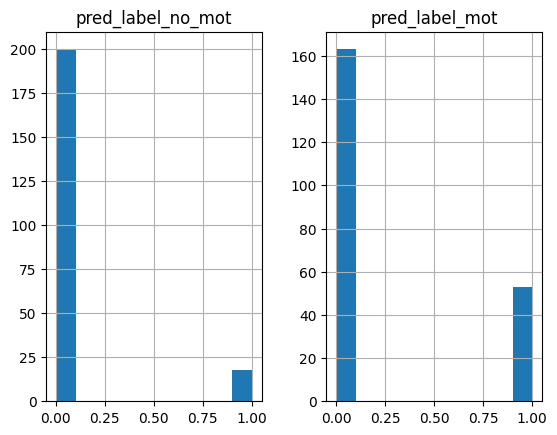

In [16]:
df[['pred_label_no_mot', 'pred_label_mot']].hist()

In [37]:
# Substitute NaN values always with the wrong label (treat them like
# missclassification).
no_mot_nan_labels = df.pred_label_no_mot.isna()
mot_nan_labels = df.pred_label_mot.isna()

df.pred_label_no_mot[no_mot_nan_labels] = 1 - df.label[
    no_mot_nan_labels]
df.pred_label_mot[mot_nan_labels] = 1 - df.label[mot_nan_labels]

df.pred_label_mot = df.pred_label_mot.astype(np.int64)
df.pred_label_no_mot = df.pred_label_no_mot.astype(np.int64)

C:\Users\Ball\AppData\Local\Temp\ipykernel_14344\3225591042.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.pred_label_no_mot[no_mot_nan_labels] = 1 - df.label[
C:\Users\Ball\AppData\Local\Temp\ipykernel_14344\3225591042.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.pred_label_mot[mot_nan_labels] = 1 - df.label[mot_nan_labels]


In [45]:
print(classification_report(df['label'], df['pred_label_no_mot']))
print(confusion_matrix(df['label'], df['pred_label_no_mot']))

              precision    recall  f1-score   support

           0       0.58      0.91      0.71       128
           1       0.39      0.08      0.13        91

    accuracy                           0.57       219
   macro avg       0.49      0.50      0.42       219
weighted avg       0.50      0.57      0.47       219

[[117  11]
 [ 84   7]]


In [47]:
print(classification_report(df['label'], df['pred_label_mot']))
print(confusion_matrix(df['label'], df['pred_label_mot']))

              precision    recall  f1-score   support

           0       0.66      0.85      0.74       128
           1       0.64      0.37      0.47        91

    accuracy                           0.65       219
   macro avg       0.65      0.61      0.61       219
weighted avg       0.65      0.65      0.63       219

[[109  19]
 [ 57  34]]


In [51]:
for _, row in df.iterrows():
    message = prompt.create_prompt(row)
    print(prompt.get_nice_prompt(message))
    
    true = verbalizer_ita[1 - row['label']]
    pred = verbalizer_ita[1 - row['pred_label_no_mot']]

    print(f"True: {true} - Predicted: {pred}")

###system
Sei un sistema automatico per l'inferenza di decisioni giudiziarie in Italia. Hai in input un estratto del verbale d'appello. Rispondi con "accolto" se è ritieni che l'appello debba essere accolto, con "respinto" altrimenti. Rispondi con una sola parola. Il verbale:
###user
###START OF USER TEXT
Con sentenza in data DD/MM/2017, la Commissione Tributaria Provinciale di Messina accoglieva ilricorso proposto dalla M S.R.L. avverso l’avviso di accertamento n. TYX03F101445/2014ritenendo nullo l'atto impugnato per assenza di prova in ordine alla qualifica del firmatario dell'avvisoe condannava l'Agenzia delle Entrate al pagamento delle spese di giudizio.Avverso tale decisione interponeva appello l'Agenzia delle Entrate chiedendone la riforma con ogniconseguenza di legge.Sosteneva la legittimità della delega e del proprio operato lamentandosi dellamancata declaratoria di interruzione del processo per l’intervenuto fallimento della società primadell'udienza di discussione del ricorso

### English prompt

In [ ]:
compute_new_column_no_mot = partial(compute_new_column, prompt_eng
                                    with_mot=False)
compute_new_column_mot = partial(compute_new_column, prompt_eng,
                                 with_mot=True)

df['pred_label_no_mot'] = df.apply(compute_new_column_no_mot, axis=1)
df['pred_label_mot'] = df.apply(compute_new_column_mot, axis=1)

You exceeded your current quota, please check your plan and billing details.
The server is overloaded or not ready yet.
The server is overloaded or not ready yet.


array([[<Axes: title={'center': 'pred_label_no_mot'}>,
        <Axes: title={'center': 'pred_label_mot'}>]], dtype=object)

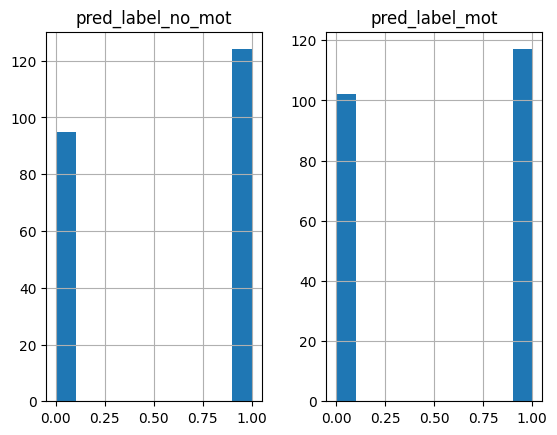

In [ ]:
df[['pred_label_no_mot', 'pred_label_mot']].hist()

In [ ]:
# Substitute NaN values always with the wrong label (treat them like
# missclassification).
no_mot_nan_labels = df.pred_label_no_mot.isna()
mot_nan_labels = df.pred_label_mot.isna()

df.pred_label_no_mot[no_mot_nan_labels] = 1 - df.label[
    no_mot_nan_labels]
df.pred_label_mot[mot_nan_labels] = 1 - df.label[mot_nan_labels]

df.pred_label_mot = df.pred_label_mot.astype(np.int64)
df.pred_label_no_mot = df.pred_label_no_mot.astype(np.int64)

C:\Users\Ball\AppData\Local\Temp\ipykernel_4412\325979723.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.pred_label_no_mot[no_mot_nan_labels] = 1 - df.label[
C:\Users\Ball\AppData\Local\Temp\ipykernel_4412\325979723.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.pred_label_mot[mot_nan_labels] = 1 - df.label[mot_nan_labels]


In [ ]:
print(classification_report(df['label'], df['pred_label_no_mot']))
print(confusion_matrix(df['label'], df['pred_label_no_mot']))

              precision    recall  f1-score   support

           0       0.61      0.45      0.52       128
           1       0.44      0.59      0.50        91

    accuracy                           0.51       219
   macro avg       0.52      0.52      0.51       219
weighted avg       0.54      0.51      0.51       219

[[58 70]
 [37 54]]


In [ ]:
print(classification_report(df['label'], df['pred_label_mot']))
print(confusion_matrix(df['label'], df['pred_label_mot']))

              precision    recall  f1-score   support

           0       0.72      0.57      0.63       128
           1       0.53      0.68      0.60        91

    accuracy                           0.62       219
   macro avg       0.62      0.63      0.62       219
weighted avg       0.64      0.62      0.62       219

[[73 55]
 [29 62]]


In [ ]:
for _, row in df.iterrows():
    message = prompt.create_prompt(row)
    print(prompt.get_nice_prompt(message))
    
    true = verbalizer_eng[1 - row['label']]
    pred = verbalizer_eng[1 - row['pred_label_no_mot']]

    print(f"True: {true} - Predicted: {pred}")

###system
You are an automated system for inferring judicial decisions in Italy. You are given an excerpt from the appellate protocol as input. Respond with "upheld" if you believe the appeal should be granted, or with "rejected" otherwise. Respond with a single word. The excerpt:
###user
###START OF USER TEXT
REPUBBLICA ITALIANA
IN NOME DEL POPOLO ITALIANO
REG.GENERALE
N° 1105/2018
LA COMMISSIONE TRIBUTARIA REGIONALE 
SEZIONE N° 10
riunita con l'intervento dei Signori:giu1 Presidentegiu2 Relatoregiu3 Giudice
ha emesso la seguente
SENTENZA
- sull'appello n. 1105/2018
depositato il DD/MM/2018
- avverso la pronuncia sentenza n. 4469/2017 Sez:2 emessa dalla Commissione
Tributaria Provinciale di MESSINA
contro:
M SRL
XXX
difeso da:
SM
XXX
proposto dall'appellante:
AG. ENTRATE DIREZIONE PROVINCIALE MESSINA
VIA SANTA CECILIA IS.104 N.45/C 98100 MESSINA ME
Atti impugnati:
AVVISO DI ACCERTAMENTO n° TYX03F101445/2014 IRES-ALTRO 2011
AVVISO DI ACCERTAMENTO n° TYX03F101445/2014 IVA-OP.IMPONIB. 20